# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.939086,True,7.187959
1,1.595018,True,7.167657
2,-1.845766,False,-2.850148
3,1.601548,True,6.820993
4,1.143279,True,6.574234
...,...,...,...
995,0.208281,True,4.484852
996,1.009224,False,0.549527
997,1.090765,True,5.079227
998,-0.373823,True,3.697504


<AxesSubplot: xlabel='v0'>

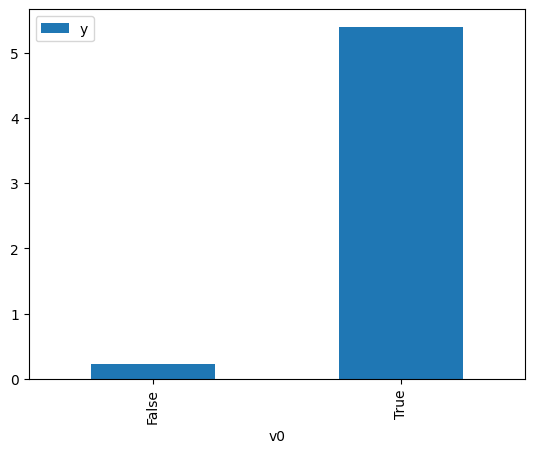

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

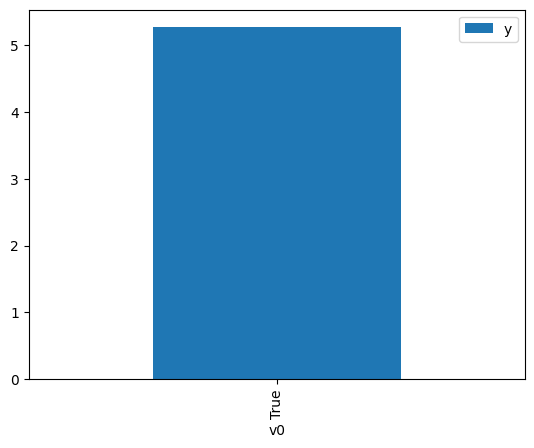

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.024632,False,-4.848371,0.706372,1.415685
1,0.443066,False,-1.256884,0.443290,2.255860
2,-0.929474,False,-2.610624,0.691287,1.446576
3,0.518554,False,0.181877,0.429305,2.329346
4,0.797756,False,2.168026,0.378713,2.640524
...,...,...,...,...,...
995,0.628619,False,0.103182,0.409121,2.444266
996,1.120262,False,1.585079,0.323449,3.091679
997,-0.642075,False,-0.248202,0.643283,1.554527
998,-1.335336,False,-0.799718,0.752481,1.328937


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.536080,True,4.641057,0.375242,2.664945
1,-0.148319,True,5.717439,0.445793,2.243193
2,0.075723,True,4.734738,0.487776,2.050123
3,2.235506,True,7.699969,0.828936,1.206366
4,1.975569,True,8.324647,0.799358,1.251003
...,...,...,...,...,...
995,0.290320,True,4.996485,0.528158,1.893371
996,-0.566760,True,4.914448,0.369840,2.703873
997,0.183012,True,4.900382,0.507978,1.968588
998,0.299458,True,5.427688,0.529874,1.887242


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              8396.
Date:                Tue, 15 Nov 2022   Prob (F-statistic):                        0.00
Time:                        09:04:10   Log-Likelihood:                         -1458.7
No. Observations:                1000   AIC:                                      2921.
Df Residuals:                     998   BIC:                                      2931.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1008      0.035     31.136      0.000       1.031       1.170
x2             5.0390      0.050    100.405      0.000       4.941       5.138
==============================================================================
Omnibus:                        8.547   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               11.036
Skew:                          -0.092   Prob(JB):                      0.00401
Kurtosis:                       3.481   Cond. No.                         1.79
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""